In [35]:
#@title Import necessary packages and set correct device

import datetime
import time

import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import spacy
import torch
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.measure import regionprops
from skimage.segmentation import slic, watershed
from skimage.util import img_as_float
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import random_split
from torchvision.ops import box_iou
from tqdm import tqdm

from modules.refcocog import RefCOCOg, RefCOCOgSample
from modules.utilities import cosine_similarity, display_preds

%matplotlib inline

if torch.cuda.is_available():
    device = torch.device("cuda")  # CUDA GPU
    print("[INFO] Using cuda.")
elif torch.has_mps:
    device = torch.device("mps")  # Apple Silicon GPU
    print("[INFO] Using MPS.")
else:
    device = torch.device("cpu")
    print("[INFO] No GPU found, using CPU instead.")


[INFO] Using MPS.


In [36]:
#@title Import RefCOCOg dataset and its train/val/test splits

# data_path = "/media/dmmp/vid+backup/Data/refcocog"
data_path = "dataset/refcocog"

dataset = RefCOCOg(ds_path=data_path)

train_ds = RefCOCOg(ds_path=data_path, split='train')
val_ds = RefCOCOg(ds_path=data_path, split='val')
test_ds = RefCOCOg(ds_path=data_path, split='test')

# keep only a toy portion of each split
keep = 0.1
red_dataset, _ = random_split(dataset, [int(keep * len(dataset)), len(dataset) - int(keep * len(dataset))])
red_train_ds, _ = random_split(train_ds, [int(keep * len(train_ds)), len(train_ds) - int(keep * len(train_ds))])
red_val_ds, _ = random_split(val_ds, [int(keep * len(val_ds)), len(val_ds) - int(keep * len(val_ds))])
red_test_ds, _ = random_split(test_ds, [int(keep * len(test_ds)), len(test_ds) - int(keep * len(test_ds))])

print(f"[INFO] Dataset Size: {len(dataset)}")
print(f"[INFO] train split:  {len(train_ds)}")
print(f"[INFO] val split:    {len(val_ds)}")
print(f"[INFO] test split:   {len(test_ds)}")


[INFO] Dataset Size: 49822
[INFO] train split:  42226
[INFO] val split:    2573
[INFO] test split:   5023


In [37]:
#@title Utility function to downsample a map

def downsample_map(map, factor):
    # number of blocks in each dimension
    blocks_h = map.shape[0] // factor
    blocks_w = map.shape[1] // factor

    # reshape the original matrix into blocks
    blocks = map[:blocks_h * factor, :blocks_w * factor].reshape(blocks_h, factor, blocks_w, factor)

    # calculate the average of each block
    averages = blocks.mean(axis=(1, 3))

    return averages


In [61]:
#@ Utility function to perform best bounding box search

def quality_f(matrix):
    # less is more :)
    return matrix.sum()


def find_best_bbox(heatmap, lower_bound=-1.0, upper_bound=1.0):
    # Rescale the heatmap
    heatmap = MinMaxScaler(feature_range=(lower_bound, upper_bound)).fit_transform(heatmap)

    # Initialize the best score and best box
    best_score = float('-inf')
    best_box = None

    # Loop over all possible box sizes and positions
    for w in range(1, heatmap.shape[1] + 1):
        for h in range(1, heatmap.shape[0] + 1):
            for i in range(heatmap.shape[1] - w + 1):
                for j in range(heatmap.shape[0] - h + 1):

                    # Get current sub-region
                    candidate = heatmap[j:j + h, i:i + w]

                    # Compute the score for this box
                    score = quality_f(candidate)

                    # Update the best score and best box if necessary
                    if score > best_score:
                        best_score = score
                        best_box = (i, j, w, h)

    return best_box


In [139]:
#@ Definition of Segmentation + CLIP visual grounding pipeline

class ClipSeg:

    def __init__(self, categories, method, n_segments=None, q=0.95, d=16, device=device, quiet=False):

        self.categories = categories
        self.method = method
        self.clip_model, self.clip_prep = clip.load("ViT-L/14", device=device)
        self.n_segments = n_segments
        self.q = q
        self.d = d
        self.device = device
        self.quiet = quiet

        if self.method not in ("s", "w"):
            raise ValueError(f"Method `{method}` not supported. Supported methods are: `s`(slic), `w`(watershed).")

        for category_id in categories.keys():
            cur_category = categories[category_id]['category']
            with torch.no_grad():
                cur_category_enc = self._encode_text(f"a photo of {cur_category}")
            categories[category_id].update({"encoding": cur_category_enc})

    def _encode_text(self, text):
        text_ = clip.tokenize(text).to(self.device)

        with torch.no_grad():
            return self.clip_model.encode_text(text_)

    def _encode_img(self, image):
        image_ = self.clip_prep(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            return self.clip_model.encode_image(image_)

    def _parse_prompt(self, sentence):
        nlp = spacy.load("en_core_web_sm")
        sent_ = nlp(sentence)

        out_sents = list()

        for chunk in sent_.noun_chunks:

            if chunk.root.dep_ != "prep":
                out_sents.append(chunk.text)

        return out_sents

    def _compute_hmap(self, img_sample, np_image, prompt, method, masks):

        hmaps = list()

        prompt_enc = self._encode_text(prompt)

        for i, n in enumerate(masks):

            # Compute regions according to chosen method

            if method == "s":
                # SLIC segmentation algorithm ()
                segments = slic(np_image, n_segments=n, compactness=10, sigma=1)
            elif method == "w":
                # Watershed segmentation algorithm ()
                segments = watershed(sobel(rgb2gray(np_image)), markers=n, compactness=0.001)

            regions = regionprops(segments)

            if len(regions) == 1:
                # If the algo returned only 1 region, skip this iteration
                # (may happen, with low-segments masks)
                continue

            # Compute CLIP encodings for each region

            images_encs = list()

            regions = tqdm(regions, desc=f"[INFO] Computing CLIP masks", leave=False) if not self.quiet else regions

            for region in regions:
                rect = region.bbox
                rect = (rect[1], rect[0], rect[3], rect[2])

                sub_image = img_sample.img.crop(rect)
                image_enc = self._encode_img(sub_image)
                images_encs.append(image_enc)

            # Assign a score to each region according to prompt similarity (creating a heatmap)

            images_encs = torch.cat(images_encs, dim=0)
            scores = prompt_enc @ images_encs.T
            scores = scores.squeeze().cpu().numpy()
            heatmap = np.zeros((segments.shape[0], segments.shape[1]))

            for i in range(segments.shape[0]):
                for j in range(segments.shape[1]):
                    heatmap[i, j] = scores[segments[i, j] - 1]

            hmaps.append(heatmap)

        # Finally, return the pooled heatmap and the list of all heatmaps computed

        pmap = np.mean(np.array(hmaps), axis=0)

        return pmap, hmaps

    def __call__(self, img_sample, prompt, show=False, show_pipeline=False, show_masks=False,
                 timeit=False):

        if timeit:
            start = time.time()

        # Convert image to np array
        np_image = img_as_float(io.imread(img_sample.path))

        p_heatmap, heatmaps = self._compute_hmap(img_sample, np_image, prompt, self.method, self.n_segments)

        # Shut down pixels below a certain threshold
        ths = np.quantile(p_heatmap.flatten(), self.q)
        fp_heatmap = p_heatmap.copy()
        fp_heatmap[p_heatmap < ths] = ths

        # Downsample the heatmap by a factor d
        dfp_heatmap = downsample_map(fp_heatmap, self.d)

        # Find the best bounding box
        pred_bbox = find_best_bbox(dfp_heatmap, lower_bound=-0.75)

        if pred_bbox is None:
            return {"IoU": 0, "cosine": 0, "euclidean": 0}

        if self.d > 1:
            pred_bbox = [pred_bbox[0] * self.d + self.d // 2,
                         pred_bbox[1] * self.d + self.d // 2,
                         pred_bbox[2] * self.d - self.d // 2,
                         pred_bbox[3] * self.d - self.d // 2]

        # Convert bbox format
        pred_bbox = [pred_bbox[0], pred_bbox[1], pred_bbox[2] + pred_bbox[0], pred_bbox[3] + pred_bbox[1]]

        # Get ground truth bbox
        gt_bbox = img_sample.bbox

        # Compute IoU
        iou = box_iou(
            torch.tensor(pred_bbox).unsqueeze(0),
            torch.tensor(gt_bbox).unsqueeze(0),
        ).item()

        # Compute distance metrics
        pred_img = img_sample.img.crop(gt_bbox)
        pred_image_enc = self._encode_img(pred_img)
        prompt_enc = self._encode_text(prompt)

        cosine_sim = cosine_similarity(prompt_enc, pred_image_enc)
        euclidean_dist = torch.cdist(prompt_enc, pred_image_enc, p=2).squeeze()
        dotproduct = prompt_enc @ pred_image_enc.T

        # Compute grounding accuracy

        all_c_sims = dict()

        for category_id in self.categories.keys():
            cur_categ = self.categories[category_id]['category']
            cur_categ_enc = self.categories[category_id]['encoding'].float()

            all_c_sims[cur_categ] = cosine_similarity(pred_image_enc, cur_categ_enc)

        pred_category = max(all_c_sims, key=all_c_sims.get)

        grd_correct = 1 if pred_category == img_sample.category else 0

        # Show all masks, if requested
        if show_masks:
            fig, axes = plt.subplots(1, len(heatmaps), figsize=(20, 5))
            for i, heatmap in enumerate(heatmaps):

                for ax in axes.ravel():
                    ax.axis("off")

                axes[i].imshow(np_image, alpha=0.25)
                axes[i].imshow(heatmap, alpha=0.75)
                axes[i].set_title(f"#{i + 1}")

        # Show the mask processing pipeline, if requested
        if show_pipeline:
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))

            for ax in axes.ravel():
                ax.axis("off")

            axes[0].imshow(np_image)
            axes[0].set_title("original image")

            axes[1].imshow(np_image, alpha=0.25)
            axes[1].imshow(p_heatmap, alpha=0.75)
            axes[1].set_title("pooled heatmap")

            axes[2].imshow(np_image, alpha=0.25)
            axes[2].imshow(fp_heatmap, alpha=0.75)
            axes[2].set_title("filtered heatmap")

            axes[3].imshow(np_image, alpha=0.25)
            w, h = np_image.shape[1], np_image.shape[0]
            dfp_heatmap_ = cv2.resize(dfp_heatmap, (w, h), interpolation=cv2.INTER_NEAREST)
            axes[3].imshow(dfp_heatmap_, alpha=0.75)
            axes[3].set_title("dsampled heatmap")

        # Show the final prediction, if requested
        if show:
            display_preds(img_sample.img, prompt, pred_bbox, img_sample.bbox, f"{''.join(self.method).upper()} + CLIP")

        # Print execution time, if requested
        if timeit:
            end = time.time()
            print(f"[INFO] Time elapsed: {end - start:.2f}s")

        return {
            "IoU": float(iou),
            "cosine": float(cosine_sim),
            "euclidean": float(euclidean_dist),
            "dotproduct": float(dotproduct),
            "grounding": float(grd_correct),
        }


Predicted category: person (ground truth: person)


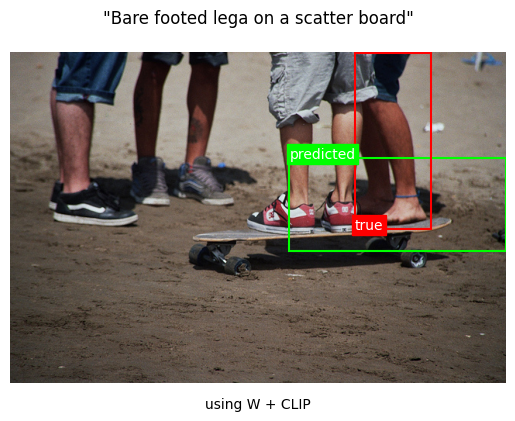

[INFO] Time elapsed: 5.02s


{'IoU': 0.1920606940984726,
 'cosine': 0.2496337890625,
 'euclidean': 1.2255859375,
 'dotproduct': 0.2496337890625,
 'grounding': 1}

In [115]:
#@tile Test ClipSeg on a random sample

idx = np.random.randint(0, len(dataset))

sample = RefCOCOgSample(**dataset[idx])

clipseg = ClipSeg(dataset.categories, method="w", n_segments=(4, 8, 16, 32), q=0.75, quiet=True)

clipseg(sample, sample.sentences[0], show_pipeline=False, show_masks=False, show=True, timeit=True)


---

In [134]:
#@title Function definition to test visual grounding with a given pipeline

def visual_grounding_test(vg_pipeline, dataset, logging=False):
    scores = list()

    pbar = tqdm(dataset)

    for sample in pbar:

        sample = RefCOCOgSample(**sample)

        for sentence in sample.sentences:

            sc = vg_pipeline(sample, sentence, show=False)

            scores.append(sc)

            avg_metrics = list()

            # The bar description is live updated with the average score for each metric

            for metric in scores[0].keys():
                avg_metric = np.mean([score[metric] for score in scores])
                avg_metric = f"{metric}: {avg_metric:.3f}"
                avg_metrics.append(avg_metric)

            pbar_desc = " | ".join(avg_metrics)

            if logging:
                pipeline_name = clipslic.__class__.__name__.lower()
                datetime_tag = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

                with open(f"{pipeline_name}_log_{datetime_tag}.txt", "a") as f:
                    f.write("[" + datetime_tag + "]" + pbar_desc + "\n")

            pbar.set_description(pbar_desc)

    for metric in scores[0].keys():
        avg_metric = np.mean([score[metric] for score in scores])

        print("Avg. {}: {:.3f}".format(metric, avg_metric))


In [140]:
#@title Execute actual testing

clipseg = ClipSeg(dataset.categories, method="w", n_segments=(4, 8, 16, 32), q=0.75, quiet=True)

visual_grounding_test(clipseg, red_test_ds)


IoU: 0.050 | cosine: 0.282 | euclidean: 1.198 | dotproduct: 0.282 | grounding: 1.000:   0%|          | 0/502 [00:21<?, ?it/s]


KeyboardInterrupt: 